In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple
from random import random
import sys
sys.path.append('../')

In [2]:
from MCTS import MCTS
from Node import Node
from Game import TicTacToe_Board
from ReplayMemory import ReplayMemory

In [82]:
# Declare NN of policy:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.l1 = nn.Linear(9, 20)
        self.l2 = nn.Linear(20, 9)
        self.l3 = nn.Linear(20,1)
        self.sm = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x1 = self.l2(x) # Logit value of policy
        x1 = self.sm(x1)
        x2 = torch.tanh(self.l3(x)) # Value head.
        return x1, x2

In [4]:
#MCTS game:
T = 0.3
state = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
end = False
player = -1

dnn = DNN()
game = TicTacToe_Board()
root = Node(state, 1, player)
mcts = MCTS(game, root, dnn)

node = root
while not end:
    mcts.explore(node)
    a = mcts.play(node, T)
    node = node.children[a]
    print(node.player)
    game.plot(node.state)
    
    end, winner = game.check_end(node.state)

1
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
-1
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
1
-------------
| o |   | x | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
-1
-------------
| o |   | x | 
-------------
| o |   |   | 
-------------
|   | x |   | 
-------------
1
-------------
| o |   | x | 
-------------
| o |   | x | 
-------------
|   | x |   | 
-------------
-1
-------------
| o |   | x | 
-------------
| o |   | x | 
-------------
| o | x |   | 
-------------


# Train loop

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [6]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



def loss_plot(loss):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    loss = np.array(loss)
    plt.plot(loss[:,0], loss[:,1])

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [147]:
CAPACITY = 1000
REPLAY_START_SIZE = 100
BATCH = 100

EPISODES = 1000

NGAMES=50

In [148]:
Transition = namedtuple('Transition',('state', 'policy', 'reward'))

In [149]:
dnn = DNN()
replay_memory = ReplayMemory(CAPACITY)

In [150]:
def loss_fn(z, v, policy, net_pol):
    a = torch.mean(torch.pow(z-v,2))
    b = (policy * torch.log(net_pol)).sum()
    return a - b

In [151]:
optimizer = torch.optim.SGD(dnn.parameters(), lr=1e-2, weight_decay=1e-4)

In [152]:
def optimize(model, optimizer, loss_fn, memory):
    if memory.__len__() < REPLAY_START_SIZE:
        return
    
    transitions = memory.sample(BATCH)
    batch = Transition(*zip(*transitions))
    
    states = torch.cat(batch.state).reshape([BATCH,-1])
    policy = torch.cat(batch.policy).reshape([BATCH,-1])
    z = torch.cat(batch.reward).reshape([BATCH,-1])
    
    net_pol, v = dnn(states)
    
    
    loss = loss_fn(z,v,policy,net_pol)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.item()

In [153]:
# Train loop:
def play_game():
    T = 0.3
    state = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
    end = False
    player = -1
    
    
    game = TicTacToe_Board()
    root = Node(state, 1, player)
    mcts = MCTS(game, root, dnn, ngames=NGAMES)
    
    node = root
    
    history = []
    while not end:
        history.append(node)
        mcts.explore(node)
        a = mcts.play(node, T)
        node = node.children[a]
        
        end, winner = game.check_end(node.state)
    
    # Save play in replaymemory
    for node in history:
        policy = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
        p = mcts.eval_policy(node, 1)
        for i, a in enumerate(game.avail_actions(node.state)):
            policy[a] = p[i]
            
        replay_memory.add(node.state, policy, torch.tensor([-winner*node.player], dtype=torch.float))
        
    return winner

In [154]:
loss_hist = []
winner = []
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Loss')

plt.ion()
for episode in range(EPISODES):
    # Play game to fill memory
    w = play_game()
    winner.append([episode, w])
    
    # Optimize
    for iopt in range(20):
        loss = optimize(dnn, optimizer, loss_fn, replay_memory)
    loss_hist.append([episode, loss])
    
    if len(winner) > 10:
        win_prob = sum(w[1] for w in winner[-10:]) / len(winner[-10:])
        print('Win mean:', win_prob)
    print('Loss:', loss)
    loss_plot(loss_hist)
    
plt.ioff()

<Figure size 432x288 with 0 Axes>

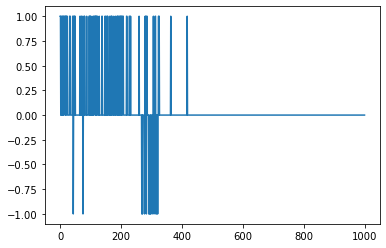

In [155]:
winner = np.array(winner)

plt.plot(winner[:,0], winner[:,1])

In [156]:
#Test:
state = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
end = False
player = -1

game = TicTacToe_Board()
root = Node(state, 1, player)
mcts = MCTS(game, root, dnn)

node = root
while not end:
    # Expand state:
    mcts.player *= -1
    actions = game.avail_actions(node.state)
    mcts.expand(node, actions)
    a = torch.argmax(torch.tensor([child.P for child in node.children]))
    print(dnn(node.state))
    node = node.children[a]
    game.plot(node.state)
    
    end, winner = game.check_end(node.state)

(tensor([1.3749e-02, 1.2155e-05, 4.9972e-03, 7.9449e-07, 1.1551e-04, 9.8059e-01,
        5.2985e-04, 4.3081e-06, 5.8526e-06], grad_fn=<SoftmaxBackward>), tensor([5.0433e-05], grad_fn=<TanhBackward>))
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
(tensor([1.4466e-03, 1.4406e-07, 2.2420e-06, 7.1025e-11, 9.9823e-01, 2.5911e-06,
        3.1005e-04, 2.4823e-08, 8.8339e-06], grad_fn=<SoftmaxBackward>), tensor([8.8550e-06], grad_fn=<TanhBackward>))
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   |   |   | 
-------------
(tensor([4.9501e-03, 2.1148e-04, 2.2442e-04, 1.3747e-07, 3.3115e-07, 1.5657e-08,
        2.4574e-03, 3.1245e-06, 9.9215e-01], grad_fn=<SoftmaxBackward>), tensor([2.8234e-05], grad_fn=<TanhBackward>))
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   |   | x | 
-------------
(tensor([6.5171e-05, 1.8541e-03, 8.9507e-01, 1.1315e-06, 8.6773e-10, 3.4337e-12,
        1.0299e-

In [113]:
state = torch.tensor([1,1,0,0,0,0,-1,0,0],dtype=torch.float)
game.plot(state)
with torch.no_grad():
    policy = dnn(-state)
print(torch.argmax(policy[0]), policy)

-------------
| x | x |   | 
-------------
|   |   |   | 
-------------
| o |   |   | 
-------------
tensor(5) (tensor([6.7941e-04, 3.8145e-03, 4.4504e-03, 1.5902e-03, 1.4563e-04, 9.8577e-01,
        5.8544e-09, 1.6703e-03, 1.8838e-03]), tensor([0.2423]))


In [114]:
state = torch.tensor([1,1,0,0,0,0,-1,0,0],dtype=torch.float)
game.plot(state)
with torch.no_grad():
    policy = dnn(state)
print(torch.argmax(policy[0]), policy)

-------------
| x | x |   | 
-------------
|   |   |   | 
-------------
| o |   |   | 
-------------
tensor(5) (tensor([4.2972e-04, 3.3410e-03, 1.8668e-01, 5.0187e-03, 4.2102e-05, 7.8348e-01,
        6.1674e-07, 8.0598e-03, 1.2950e-02]), tensor([-0.0011]))


In [157]:
T = 0.3
state = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
end = False
player = -1


game = TicTacToe_Board()
root = Node(state, 1, player)
mcts = MCTS(game, root, dnn, ngames=NGAMES)

node = root

history = []
while not end:
    history.append(node)
    mcts.explore(node)
    a = mcts.play(node, T)
    node = node.children[a]
    
    end, winner = game.check_end(node.state)

# Save play in replaymemory
for node in history:
    policy = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
    p = mcts.eval_policy(node, 1)
    for i, a in enumerate(game.avail_actions(node.state)):
        policy[a] = p[i]
        
    game.plot(node.state)
    print(policy, node.Q)
    with torch.no_grad():
        print(dnn(node.state))
    
    replay_memory.add(node.state, policy, torch.tensor([-winner*node.player], dtype=torch.float))

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
tensor([0.0204, 0.0000, 0.0000, 0.0000, 0.0000, 0.9796, 0.0000, 0.0000, 0.0000]) 0.0
(tensor([1.3749e-02, 1.2155e-05, 4.9972e-03, 7.9449e-07, 1.1551e-04, 9.8059e-01,
        5.2985e-04, 4.3081e-06, 5.8526e-06]), tensor([5.0433e-05]))
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
tensor([0.0103, 0.0000, 0.0000, 0.0000, 0.9897, 0.0000, 0.0000, 0.0000, 0.0000]) tensor([0.0239])
(tensor([1.4466e-03, 1.4406e-07, 2.2420e-06, 7.1025e-11, 9.9823e-01, 2.5911e-06,
        3.1005e-04, 2.4823e-08, 8.8339e-06]), tensor([8.8550e-06]))
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   |   |   | 
-------------
tensor([0.0069, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9931]) tensor([-0.0112])
(tensor([4.9501e-03, 2.1148e-04, 2.2442e-04, 1.3747e-07, 3.3115e-07, 1.5657e-08,
        2.4574e-03, 3.1245e-06, 9.92

In [171]:
#Test:
state = torch.tensor([ 1., -1.,  1., -1., -1.,  1,  0.,  1.,  0.],dtype=torch.float)
end = False
player = 1

game = TicTacToe_Board()
root = Node(state, 1, player)
mcts = MCTS(game, root, dnn)

game.plot(state)
node = root
# Expand state:
mcts.player *= -1
actions = game.avail_actions(node.state)
mcts.expand(node, actions)
a = torch.argmax(torch.tensor([child.P for child in node.children]))
node = node.children[a]
game.plot(node.state)

end, winner = game.check_end(node.state)
print(node.state)

-------------
| x | o | x | 
-------------
| o | o | x | 
-------------
|   | x |   | 
-------------
-------------
| x | o | x | 
-------------
| o | o | x | 
-------------
|   | x | o | 
-------------
tensor([ 1., -1.,  1., -1., -1.,  1.,  0.,  1., -1.])
